<a href="https://colab.research.google.com/github/tXiao95/py_experiments/blob/master/ResNetPeaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 584 HW 6: Your First ResNet




In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys, os
sys.path.append('/content/gdrive/My Drive/CS584/Project5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import Packages and Load Data



In [0]:
import torch
import torch.nn as nn
# low level access to convolutions
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from torchvision import datasets, transforms

# import CS584 files
import setupPeaksClass as data

## Generate Test Data

In [0]:
n = 1000;
Y,C = data.getData(n);
Yv,Cv = data.getData(n);
print(Y.shape)
print(C.shape)

torch.Size([1000, 2])
torch.Size([1000, 5])


## Residual Neural Network

Use this simple implementation of the ResNet.

In [0]:
class ResNet(): 
  """Class that only defines activation function and method of
  feedforward, nothing else"""
  def __init__(self,act=torch.tanh):
    self.act = act
  def forward(self, Ks, bs, x):
    X = [] # all hidden features
    A = [] # all activations 
    for l in range(len(Ks)):
      if  Ks[l].shape[0]==Ks[l].shape[1]:
        # If K is a square matrix, then use residual form (x + residual)
        a = self.act(torch.mm(x,Ks[l])+bs[l])
        # Previous input plus (x) plus residual (a)
        x = x + a
      else:
        # If K is not a square matrix, then use normal NN composition? So 
        # Only applies to input -->> first hidden layer (8 x 2)
        a = self.act(torch.mm(x,Ks[l])+bs[l])
        x = a
      X.append(x)
      A.append(a)
    return x, X, A

## Define the Network Architecture, Initialize Weights, and Test Network

In [70]:
m = [2, 8, 8, 8, 8, 8, 8, 8] # change this to vary the depth or width
Ks = []
bs = []
for l in range(len(m)-1):
  print("layer %d, input=%d, output %d"  % (l+1,m[l],m[l+1]))
  # N(0,1) initialization for weights
  Ks.append(torch.randn((m[l],m[l+1]), requires_grad=True,dtype=torch.float32))
  # Zeros initialization for bias
  bs.append(torch.zeros((1,m[l+1]), requires_grad=True,dtype=torch.float32))

net = ResNet(act=torch.tanh)
Z,X,A = net.forward(Ks,bs,Y)

layer 1, input=2, output 8
layer 2, input=8, output 8
layer 3, input=8, output 8
layer 4, input=8, output 8
layer 5, input=8, output 8
layer 6, input=8, output 8
layer 7, input=8, output 8


## Softmax Loss Function

In [71]:
def softmaxLoss(W,b,Y,C):
    """Scalar valued loss function"""
    n = Y.shape[0]
    YW = torch.mm(Y,W) + b
    YW = YW - torch.max(YW,1,keepdim=True)[0]
    S  = torch.exp(YW)
    return (-torch.sum(C * YW) + torch.sum(torch.log(torch.sum(S,1))))/n , S

def getC(W,b,Y):
    """Retrieve class prediction vector from resnet"""
    nc = C.shape[1]
    YW = torch.mm(Y,W) + b
    YW = YW - torch.max(YW,1,keepdim=True)[0]
    S  = torch.exp(YW)
    P  = S / torch.sum(S, 1, keepdim=True)
    c = torch.argmax(P,1,keepdim=True)
    Cp = 1.0*(c == torch.tensor(range(nc),device=Y.device).reshape(1,-1))
    return Cp

# W and b for last hidden layer (8 nodes) -->> output layer (5 classes)
W = torch.randn((m[-1],5), requires_grad=True);
b = torch.randn((1,5), requires_grad=True)
loss,S = softmaxLoss(W,b,Z,C)
print("initial loss=%1.3f" % loss)

initial loss=5.507


Helper Functions

## Define Optimizer and Compute Gradient of Loss

In [67]:
optimizer = torch.optim.SGD([*Ks,*bs,W,b],lr=0.01) # experiment with optmizers learning rates, ....

optimizer.zero_grad()
Z,X,A = net.forward(Ks,bs,Y)
loss,S = softmaxLoss(W,b,Z,C)
loss.backward()
with torch.no_grad():
  # Use torch.no_grad() because we do not need the gradients for the computation
  # of the result C, even though we require the gradients for its inputs W, b, Z
  Cp = getC(W,b,Z)
  Zv,Xv,Av = net.forward(Ks,bs,Yv)
  Cvp = getC(W,b,Zv)

trainErr0 = torch.sum(torch.abs(C-Cp))/(2.0*C.shape[0])
testErr0 = torch.sum(torch.abs(Cv-Cvp))/(2.0*Cv.shape[0])
print("training error=%1.2f%%, validation error=%1.2f%%" % (trainErr0*100, testErr0*100))

training error=76.20%, validation error=74.70%


## Plot Gradients and Activations for Initial Guess 

It's interesting to compare these to the ones from the multilayer perceptron.



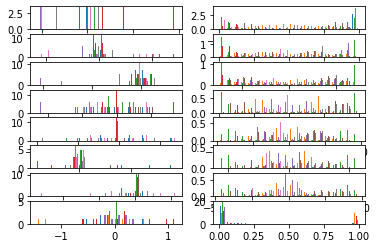

In [62]:
nLayers = len(Ks)+1
for k in range(len(Ks)):
  # Histograms of gradients and activation values
  meanK = torch.mean(Ks[k].grad).item()
  stdK = torch.std(Ks[k].grad).item()
  #print(torch.mean(Ks[k].grad).item())
  plt.subplot(nLayers,2,2*k+1)
  plt.hist(Ks[k].grad.detach().numpy(),density=True,bins=20)
  plt.subplot(nLayers,2,2*(k+1))
  plt.hist(X[k].detach().numpy(),density=True,bins=20)

plt.subplot(nLayers,2,2*nLayers-1)
plt.hist(W.grad.detach().numpy(),density=True,bins=20)
plt.subplot(nLayers,2,2*nLayers)
plt.hist(S.detach().numpy(),density=True,bins=20)

plt.show()

In [0]:
# Your main task: optimization
def onestep(net, optimizer, Ks, bs, W, b, Y, Yv, C, Cvp, loss_fn):
  """One epoch for a model of class MLP"""
  Z,X,A = net.forward(Ks,bs,Y)
  loss,S = softmaxLoss(W,b,Z,C)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    Cp = getC(W,b,Z)
    Zv,Xv,Av = net.forward(Ks,bs,Yv)
    Cvp = getC(W,b,Zv)
  
  trainErr = 100*torch.sum(torch.abs(C-Cp))/(2.0*C.shape[0])
  testErr = 100*torch.sum(torch.abs(Cv-Cvp))/(2.0*Cv.shape[0])

  return loss.data, trainErr, testErr

optimizer = torch.optim.SGD([*Ks,*bs,W,b],lr=0.01) # experiment with optmizers learning rates, ....

In [73]:
numEpoch = 20000

Loss = torch.empty(numEpoch)
TrainError = torch.empty(numEpoch)
TestError = torch.empty(numEpoch)

for i in range(numEpoch):
  Loss[i], TrainError[i], TestError[i] = onestep(net, optimizer, Ks, bs, W, b, Y, Yv, C, Cv, softmaxLoss)
  if i % 1000 == 99:
    print("Iteration {}".format(i))
    print("Loss: {}".format(Loss[i]))
    print("Train Error: {}".format(TrainError[i]))
    print("Test Error: {}".format(TestError[i]))
    print("\n")

Iteration 99
Loss: 0.9333023428916931
Train Error: 33.79999923706055
Test Error: 34.0


Iteration 1099
Loss: 0.3837903141975403
Train Error: 16.600000381469727
Test Error: 15.600000381469727


Iteration 2099
Loss: 0.31336626410484314
Train Error: 12.5
Test Error: 13.699999809265137


Iteration 3099
Loss: 0.2720608413219452
Train Error: 10.0
Test Error: 11.300000190734863


Iteration 4099
Loss: 0.22435955703258514
Train Error: 8.100000381469727
Test Error: 9.699999809265137


Iteration 5099
Loss: 0.17235176265239716
Train Error: 5.400000095367432
Test Error: 7.599999904632568


Iteration 6099
Loss: 0.15361995995044708
Train Error: 5.300000190734863
Test Error: 6.800000190734863


Iteration 7099
Loss: 0.14391623437404633
Train Error: 5.300000190734863
Test Error: 6.300000190734863


Iteration 8099
Loss: 0.14408518373966217
Train Error: 5.5
Test Error: 6.699999809265137


Iteration 9099
Loss: 0.09979457408189774
Train Error: 3.0
Test Error: 5.099999904632568


Iteration 10099
Loss: 0.1035

In [74]:
with torch.no_grad():
  Z,X,A = net.forward(Ks,bs,Y)
  Cp = getC(W,b,Z)
  Zv,Xv,Av = net.forward(Ks,bs,Yv)
  Cvp = getC(W,b,Zv)

trainErr = torch.sum(torch.abs(C-Cp))/(2.0*C.shape[0])
testErr = torch.sum(torch.abs(Cv-Cvp))/(2.0*Cv.shape[0])
print("training error=%1.2f%%, validation error=%1.2f%%" % (trainErr*100, testErr*100))

training error=0.80%, validation error=4.20%


Text(0.5, 0, 'epoch')

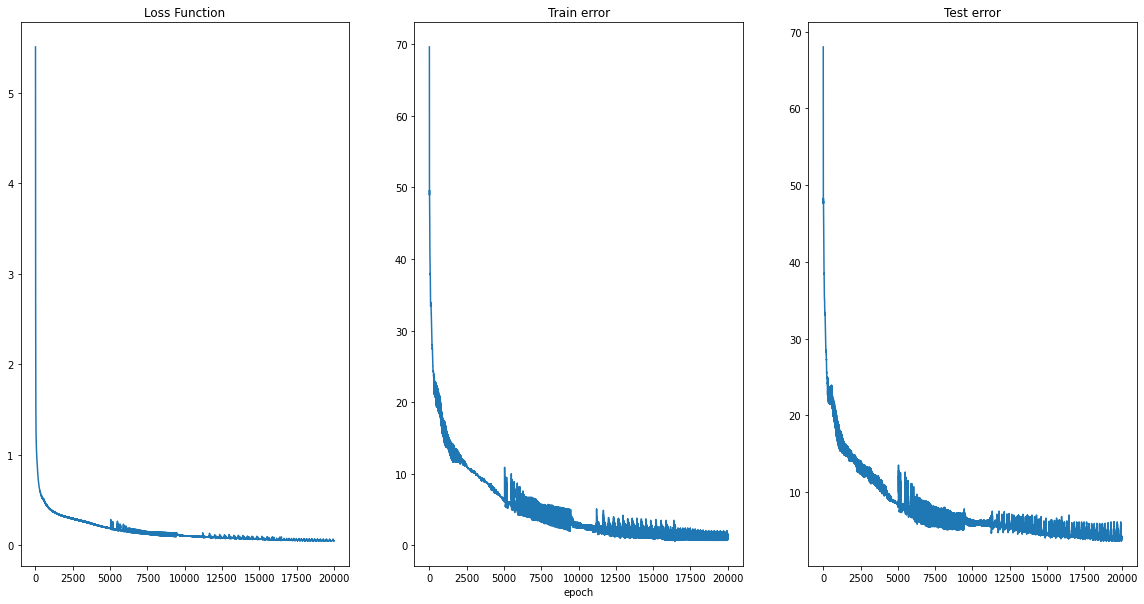

In [82]:
fig, ax = plt.subplots(1, 3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].plot(Loss)
ax[0].set_title("Loss Function")
ax[1].plot(TrainError)
ax[1].set_title("Train error")
ax[2].plot(TestError)
ax[2].set_title("Test error")

ax[1].set_xlabel('epoch')

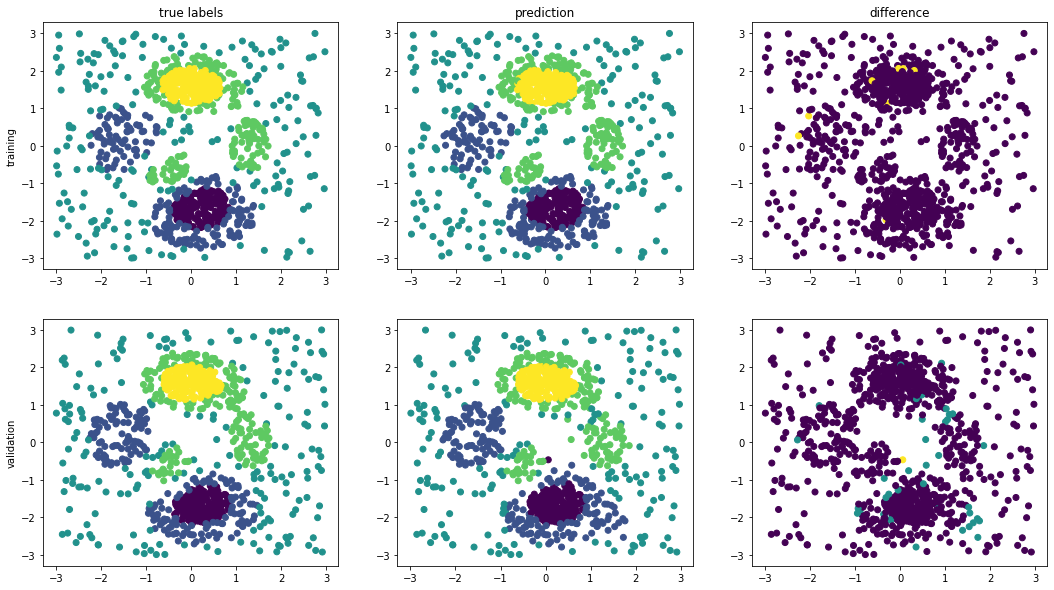

In [86]:
v = 1.0+1.0*torch.tensor(range(5),dtype=torch.float32).reshape(-1,1)
lv = torch.mm(1.0*Cv,v)
lvp = torch.mm(1.0*Cvp,v)
l = torch.mm(1.0*C,v)
lp = torch.mm(1.0*Cp,v)

plt.figure(figsize=(18, 10))
plt.subplot(2,3,1)
plt.scatter(Y[:, 0].numpy(), Y[:, 1].numpy(), c=l.numpy())
plt.ylabel("training")
plt.title("true labels")

plt.subplot(2,3,2)
plt.scatter(Y[:, 0].numpy(), Y[:, 1].numpy(), c=lp.numpy())
plt.title("prediction")

plt.subplot(2,3,3)
plt.scatter(Y[:, 0].numpy(), Y[:, 1].numpy(), c=(torch.abs(lp-l)).numpy())
plt.title("difference")

plt.subplot(2,3,4)
plt.scatter(Yv[:, 0].numpy(), Yv[:, 1].numpy(), c=lv.numpy())
plt.ylabel("validation")

plt.subplot(2,3,5)
plt.scatter(Yv[:, 0].numpy(), Yv[:, 1].numpy(), c=lvp.numpy())

plt.subplot(2,3,6)
plt.scatter(Yv[:, 0].numpy(), Yv[:, 1].numpy(), c=(torch.abs(lvp-lv)).numpy())

plt.show()
